In [1]:
import numpy as np
import sklearn
import pandas as pd
from IPython.display import display
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, StratifiedShuffleSplit
from sklearn import preprocessing
from sklearn.metrics import roc_curve, precision_score, accuracy_score, average_precision_score, recall_score, f1_score, classification_report, confusion_matrix
import os
from collections import Counter

pd.options.display.max_columns = None
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('figure', figsize=[10,5])

np.random.seed(999)

## Models

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

## Metrics

In [3]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is None:
        ylim = [0, 1]
    plt.ylim(*ylim)
        
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()
    

# Load Datasets

In [4]:
data_wine = pd.read_csv('wine.csv')
data_volcanoes = pd.read_csv('volcanoes-a4.csv', index_col=0)

In [5]:
data_wine.head()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,Od_Hod_of_diluted_wines,Proline
0,1,13.761443,0.972960,2.191146,14.349954,106.525734,2.288580,2.584551,0.418044,1.862804,3.086808,1.169861,2.819086,850.678431
1,2,11.897923,1.297780,2.199666,17.478054,104.205421,2.716657,1.855066,0.318077,1.029640,9.103668,1.353718,2.780333,332.922006
2,3,12.659632,1.748552,2.438597,21.584696,88.079451,1.919476,0.681341,0.538078,1.327974,8.803633,0.643678,1.569951,633.531687
3,1,13.054828,1.817559,1.893926,15.390157,108.589893,2.662509,2.815723,0.278535,1.473812,6.386732,0.820398,3.694865,880.103325
4,3,11.769431,3.017528,3.013448,17.081528,86.525235,2.224963,0.846229,0.286065,1.644007,10.383464,0.734288,2.747013,475.152492


In [6]:
data_volcanoes.head()

,V1,V2,V3,Class
id,,,,
1,291,802,0.575356,2
2,234,656,0.588769,2
3,332,698,0.451603,2
4,352,772,0.567596,2
5,41,809,0.754151,2


In [7]:
data_wine.describe()

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,Od_Hod_of_diluted_wines,Proline
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.966600,12.995186,2.330916,2.370151,19.496761,99.072699,2.300694,2.057249,0.362036,1.590397,5.086170,0.962753,2.609474,744.635286
std,0.772272,0.814378,1.118433,0.274757,3.351535,13.951364,0.617459,0.992019,0.124728,0.566114,2.337002,0.225385,0.704532,313.348736
min,1.000000,10.991005,0.478367,1.447951,10.366806,68.871553,0.969383,0.277914,0.109327,0.099295,1.129366,0.414259,1.112145,231.883252
25%,1.000000,12.386366,1.592804,2.236354,17.372474,88.827614,1.791985,1.223907,0.270011,1.238714,3.271563,0.802881,1.996074,507.083531
50%,2.000000,13.026910,1.867287,2.369439,19.383204,97.561288,2.324534,2.138558,0.335068,1.546307,4.745563,0.977078,2.770427,665.609642
75%,3.000000,13.624392,2.940638,2.542378,21.429700,105.978061,2.755317,2.808482,0.442366,1.888451,6.214175,1.104621,3.146931,948.204369
max,3.000000,14.802882,6.242546,3.167812,30.236014,164.765854,3.882879,4.397836,0.756410,3.700137,13.120260,1.603007,4.032795,1782.712893


In [8]:
Counter(data_wine['class'])

Counter({1: 1577, 2: 2013, 3: 1410})

In [9]:
data_volcanoes.describe()

,V1,V2,V3,Class
count,1515.000000,1515.000000,1515.000000,1515.000000
mean,501.908251,505.172937,0.436134,1.262706
std,286.734445,297.135809,0.083807,0.866766
min,16.000000,16.000000,0.350016,1.000000
25%,257.000000,241.000000,0.372818,1.000000
50%,500.000000,513.000000,0.410634,1.000000
75%,738.500000,759.000000,0.472479,1.000000
max,1006.000000,1008.000000,0.787393,5.000000


In [10]:
Counter(data_volcanoes['Class'])

Counter({2: 33, 3: 29, 4: 45, 5: 43, 1: 1365})

# Pre-processing

In [13]:
def preprossesor(df, label_column, test_size=0.2, random_state=99):
    y = df[label_column].values
    X_cols = df.columns.tolist()
    X_cols.remove(label_column)
    X = df[X_cols].values
    min_max_scaler = preprocessing.MinMaxScaler()
    X_scaled = min_max_scaler.fit_transform(X)
    
    split = StratifiedShuffleSplit(n_splits=1 , test_size=test_size, random_state=random_state)
    for train_id, test_id in split.split(X_scaled, y):
        X_train = X_scaled[train_id]
        X_test = X_scaled[test_id]
        y_train = y[train_id]
        y_test = y[test_id]
    
    return {
        'X': X_scaled,
        'y': y,
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test
}


In [14]:
dataset_wine = preprossesor(data_wine, 'class', test_size=0.2, random_state=99)
dataset_volcanoes = preprossesor(data_volcanoes, 'Class', test_size=0.2, random_state=99)

# Decision Tree

In [15]:
def decision_tree(data, title):
    param_grid = {
        'criterion': ['gini', 'entropy'],
        'ccp_alpha': [0.02, 0.014, 0.01, 0.008, 0.006, 0.004, 0.002, 0.001],
        'max_depth': [3, 5, 7, 9]
    }
    searcher = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10, 
                          scoring='f1_weighted', n_jobs=-1)
    searcher.fit(data['X_train'], data['y_train'])
    print(searcher.best_estimator_) 
    print('best score:', searcher.best_score_)
    
    estimator = DecisionTreeClassifier(criterion=searcher.best_estimator_.criterion, 
                                       max_depth=searcher.best_estimator_.max_depth,
                                      ccp_alpha=searcher.best_estimator_.ccp_alpha)
    
    plot_learning_curve(estimator, title, data['X'], data['y'], ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
    
    estimator.fit(data['X_train'], data['y_train'])
    test_pred = estimator.predict(data['X_test'])
    print(classification_report(data['y_test'], test_pred,digits=5))
    print(confusion_matrix(data['y_test'], test_pred))


DecisionTreeClassifier(ccp_alpha=0.006, criterion='entropy', max_depth=5)
best score: 0.8833942317954377


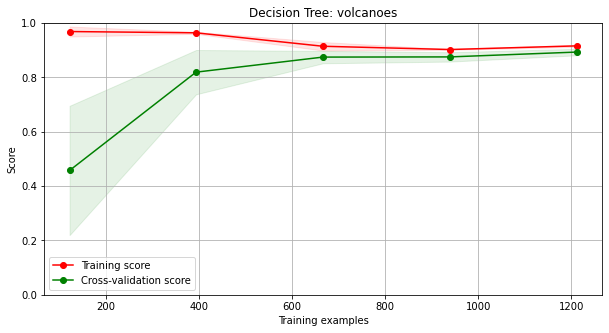

              precision    recall  f1-score   support

           1    0.93007   0.97436   0.95170       273
           2    0.00000   0.00000   0.00000         6
           3    0.00000   0.00000   0.00000         6
           4    0.33333   0.11111   0.16667         9
           5    0.14286   0.11111   0.12500         9

    accuracy                        0.88449       303
   macro avg    0.28125   0.23932   0.24867       303
weighted avg    0.85213   0.88449   0.86614       303

[[266   0   2   2   3]
 [  4   0   0   0   2]
 [  5   1   0   0   0]
 [  6   0   1   1   1]
 [  5   0   3   0   1]]


In [16]:
decision_tree(dataset_volcanoes, 'Decision Tree: volcanoes')

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=7)
best score: 0.90548233539037


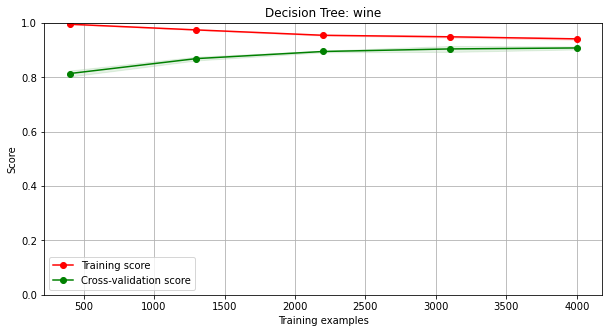

              precision    recall  f1-score   support

           1    0.93417   0.94603   0.94006       315
           2    0.91214   0.87593   0.89367       403
           3    0.86735   0.90426   0.88542       282

    accuracy                        0.90600      1000
   macro avg    0.90455   0.90874   0.90638      1000
weighted avg    0.90645   0.90600   0.90596      1000

[[298   9   8]
 [ 19 353  31]
 [  2  25 255]]


In [17]:
decision_tree(dataset_wine, 'Decision Tree: wine')

# Neural Networks

In [18]:
def neural_network(data, title):
    param_grid = {
    'hidden_layer_sizes': [(8,16), (16,32), (32,64)],
    "alpha" : [1e-1, 1e-2, 1e-3],
    'learning_rate': ['constant', 'invscaling'],
}
    searcher = GridSearchCV(MLPClassifier(), param_grid, cv=10, 
                          scoring='f1_weighted', n_jobs=-1)
    searcher.fit(data['X_train'], data['y_train'])
    print(searcher.best_estimator_) 
    print('best score:', searcher.best_score_)
    
    estimator = MLPClassifier(hidden_layer_sizes=searcher.best_estimator_.hidden_layer_sizes, 
                                       alpha=searcher.best_estimator_.alpha,
                                      learning_rate=searcher.best_estimator_.learning_rate)
    
    plot_learning_curve(estimator, title, data['X'], data['y'], ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
    
    estimator.fit(data['X_train'], data['y_train'])
    test_pred = estimator.predict(data['X_test'])
    print(classification_report(data['y_test'], test_pred,digits=5))
    print(confusion_matrix(data['y_test'], test_pred))


MLPClassifier(alpha=0.001, hidden_layer_sizes=(32, 64),
              learning_rate='invscaling')
best score: 0.8757172991857111


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multi

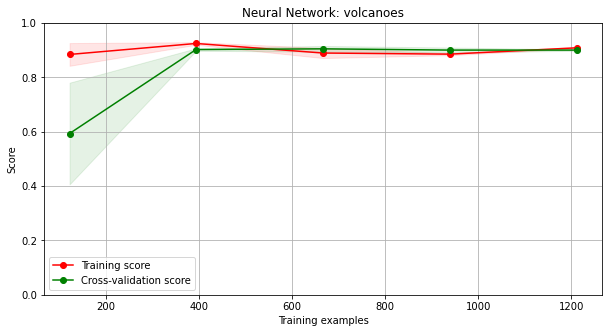

              precision    recall  f1-score   support

           1    0.92230   1.00000   0.95958       273
           2    0.00000   0.00000   0.00000         6
           3    0.00000   0.00000   0.00000         6
           4    1.00000   0.22222   0.36364         9
           5    0.20000   0.11111   0.14286         9

    accuracy                        0.91089       303
   macro avg    0.42446   0.26667   0.29321       303
weighted avg    0.86662   0.91089   0.87961       303

[[273   0   0   0   0]
 [  4   0   0   0   2]
 [  5   0   0   0   1]
 [  6   0   0   2   1]
 [  8   0   0   0   1]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
neural_network(dataset_volcanoes, 'Neural Network: volcanoes')

/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(alpha=0.1, hidden_layer_sizes=(32, 64))
best score: 0.9244785430164362


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multi

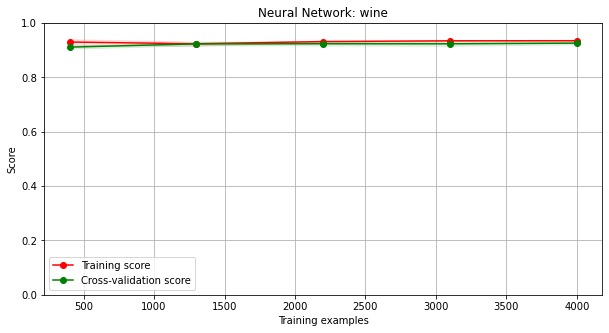

              precision    recall  f1-score   support

           1    0.92790   0.93968   0.93375       315
           2    0.94402   0.92060   0.93216       403
           3    0.93403   0.95390   0.94386       282

    accuracy                        0.93600      1000
   macro avg    0.93532   0.93806   0.93659      1000
weighted avg    0.93612   0.93600   0.93596      1000

[[296  13   6]
 [ 19 371  13]
 [  4   9 269]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [20]:
neural_network(dataset_wine, 'Neural Network: wine')

# Boosting

In [21]:
def boosting(data, title):
    param_grid = {
    'n_estimators': [25, 50, 100],
        'learning_rate': [1, 0.5, 0.1]
    }
    searcher = GridSearchCV(AdaBoostClassifier(), param_grid, cv=10, 
                          scoring='f1_weighted', n_jobs=-1)
    searcher.fit(data['X_train'], data['y_train'])
    print(searcher.best_estimator_) 
    print('best score:', searcher.best_score_)
    
    estimator = AdaBoostClassifier(n_estimators=searcher.best_estimator_.n_estimators, 
                                       learning_rate=searcher.best_estimator_.learning_rate)
    
    plot_learning_curve(estimator, title, data['X'], data['y'], ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
    
    estimator.fit(data['X_train'], data['y_train'])
    test_pred = estimator.predict(data['X_test'])
    print(classification_report(data['y_test'], test_pred,digits=5))
    print(confusion_matrix(data['y_test'], test_pred))


AdaBoostClassifier(learning_rate=0.1, n_estimators=100)
best score: 0.8785821212116538


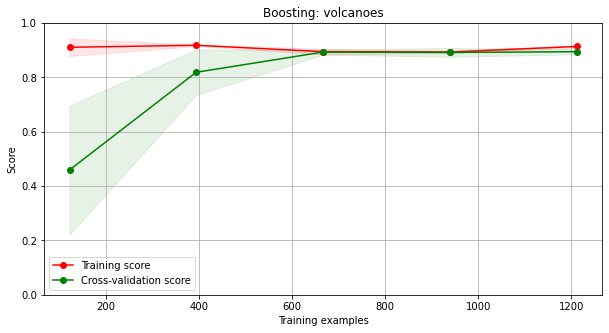

              precision    recall  f1-score   support

           1    0.92491   0.99267   0.95760       273
           2    0.00000   0.00000   0.00000         6
           3    0.50000   0.16667   0.25000         6
           4    0.50000   0.11111   0.18182         9
           5    0.20000   0.11111   0.14286         9

    accuracy                        0.90429       303
   macro avg    0.42498   0.27631   0.30645       303
weighted avg    0.86403   0.90429   0.87738       303

[[271   0   0   1   1]
 [  4   0   0   0   2]
 [  4   1   1   0   0]
 [  7   0   0   1   1]
 [  7   0   1   0   1]]


In [22]:
boosting(dataset_volcanoes, 'Boosting: volcanoes')

AdaBoostClassifier(learning_rate=0.5, n_estimators=100)
best score: 0.9259902145973016


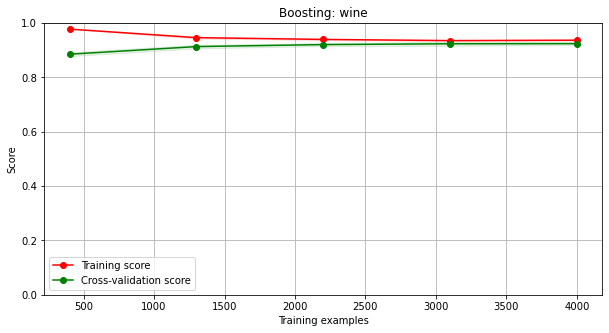

              precision    recall  f1-score   support

           1    0.92331   0.95556   0.93916       315
           2    0.95078   0.91067   0.93029       403
           3    0.92708   0.94681   0.93684       282

    accuracy                        0.93500      1000
   macro avg    0.93372   0.93768   0.93543      1000
weighted avg    0.93544   0.93500   0.93493      1000

[[301   8   6]
 [ 21 367  15]
 [  4  11 267]]


In [23]:
boosting(dataset_wine, 'Boosting: wine')

# SVM

In [24]:
def svm(data, title):
    param_grid = {
    'kernel': ['linear', 'poly', 'rbf'],
    'C' : [0.5, 1.0, 2.0],
    'degree': [2, 3, 4, 5],
    'gamma': ['scale', 'auto']
}
    searcher = GridSearchCV(SVC(), param_grid, cv=10, 
                          scoring='f1_weighted', n_jobs=-1)
    searcher.fit(data['X_train'], data['y_train'])
    print(searcher.best_estimator_) 
    print('best score:', searcher.best_score_)
    
    estimator = SVC(kernel=searcher.best_estimator_.kernel, 
                    C=searcher.best_estimator_.C,
                   degree=searcher.best_estimator_.degree,
                   gamma=searcher.best_estimator_.gamma)
    
    plot_learning_curve(estimator, title, data['X'], data['y'], ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
    
    estimator.fit(data['X_train'], data['y_train'])
    test_pred = estimator.predict(data['X_test'])
    print(classification_report(data['y_test'], test_pred,digits=5))
    print(confusion_matrix(data['y_test'], test_pred))


SVC(degree=4, kernel='poly')
best score: 0.8786096751131274


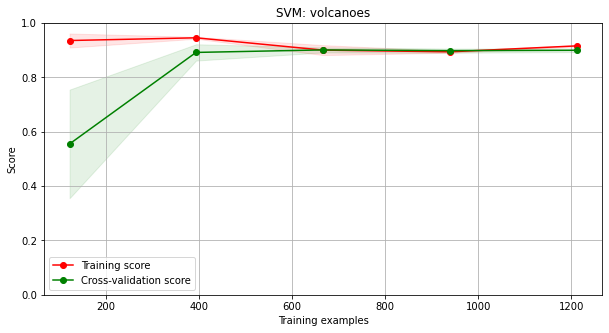

              precision    recall  f1-score   support

           1    0.91892   0.99634   0.95606       273
           2    0.00000   0.00000   0.00000         6
           3    0.00000   0.00000   0.00000         6
           4    0.66667   0.22222   0.33333         9
           5    0.25000   0.11111   0.15385         9

    accuracy                        0.90759       303
   macro avg    0.36712   0.26593   0.28865       303
weighted avg    0.85516   0.90759   0.87587       303

[[272   0   0   1   0]
 [  4   0   0   0   2]
 [  5   0   0   0   1]
 [  7   0   0   2   0]
 [  8   0   0   0   1]]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
svm(dataset_volcanoes, 'SVM: volcanoes')

SVC(degree=2)
best score: 0.9289866737506781


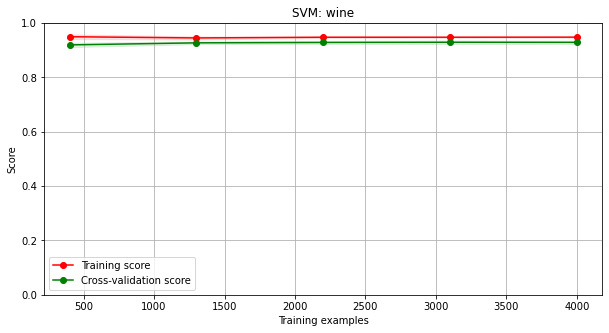

              precision    recall  f1-score   support

           1    0.92547   0.94603   0.93564       315
           2    0.94133   0.91563   0.92830       403
           3    0.93357   0.94681   0.94014       282

    accuracy                        0.93400      1000
   macro avg    0.93345   0.93616   0.93469      1000
weighted avg    0.93414   0.93400   0.93395      1000

[[298  12   5]
 [ 20 369  14]
 [  4  11 267]]


In [32]:
svm(dataset_wine, 'SVM: wine')

# KNN

In [27]:
def knn(data, title):
    param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'leaf_size' : [10, 20, 30, 40, 50],
    'weights': ['uniform', 'distance']
}
    searcher = GridSearchCV(KNeighborsClassifier(), param_grid, cv=10, 
                          scoring='f1_weighted', n_jobs=-1)
    searcher.fit(data['X_train'], data['y_train'])
    print(searcher.best_estimator_) 
    print('best score:', searcher.best_score_)
    
    estimator = KNeighborsClassifier(n_neighbors=searcher.best_estimator_.n_neighbors,
                                     leaf_size=searcher.best_estimator_.leaf_size,
                             weights=searcher.best_estimator_.weights)
    
    plot_learning_curve(estimator, title, data['X'], data['y'], ylim=[0.3, 1.2], cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5))
    
    estimator.fit(data['X_train'], data['y_train'])
    test_pred = estimator.predict(data['X_test'])
    print(classification_report(data['y_test'], test_pred,digits=5))
    print(confusion_matrix(data['y_test'], test_pred))


KNeighborsClassifier(leaf_size=10, n_neighbors=3, weights='distance')
best score: 0.8883597084920203


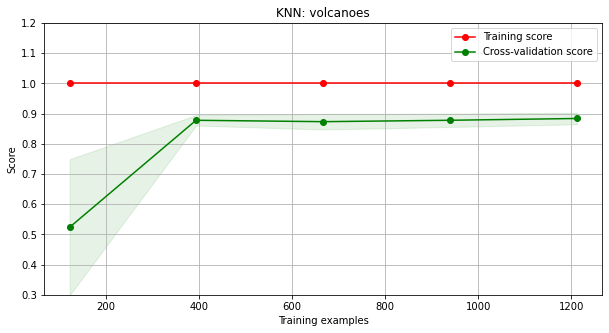

              precision    recall  f1-score   support

           1    0.94526   0.94872   0.94698       273
           2    0.00000   0.00000   0.00000         6
           3    0.00000   0.00000   0.00000         6
           4    0.13333   0.22222   0.16667         9
           5    0.00000   0.00000   0.00000         9

    accuracy                        0.86139       303
   macro avg    0.21572   0.23419   0.22273       303
weighted avg    0.85563   0.86139   0.85817       303

[[259   1   1   9   3]
 [  3   0   0   0   3]
 [  4   2   0   0   0]
 [  3   1   2   2   1]
 [  5   0   0   4   0]]


In [28]:
knn(dataset_volcanoes, 'KNN: volcanoes')

KNeighborsClassifier(leaf_size=10, n_neighbors=10, weights='distance')
best score: 0.923713350305805


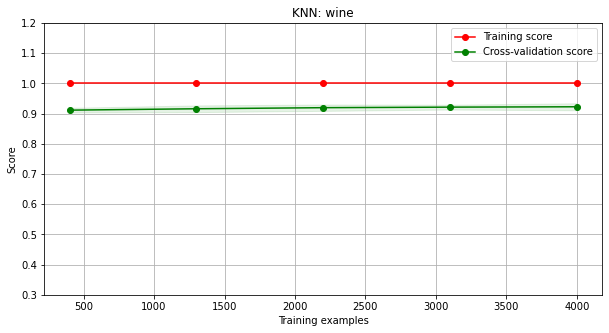

              precision    recall  f1-score   support

           1    0.90881   0.94921   0.92857       315
           2    0.93606   0.90819   0.92191       403
           3    0.94286   0.93617   0.93950       282

    accuracy                        0.92900      1000
   macro avg    0.92924   0.93119   0.93000      1000
weighted avg    0.92940   0.92900   0.92897      1000

[[299  11   5]
 [ 26 366  11]
 [  4  14 264]]


In [30]:
knn(dataset_wine, 'KNN: wine')